In [194]:
%matplotlib inline

In [195]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os

def findFiles(path): return glob.glob(path)

print(findFiles('data/names/*.txt'))

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8', errors='ignore').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

# for filename in findFiles('data/names/*.txt'):
#     category = os.path.splitext(os.path.basename(filename))[0]
#     all_categories.append(category)
#     lines = readLines(filename)
#     category_lines[category] = lines

# n_categories = len(all_categories)

[]
Slusarski


In [196]:
global num_tot_train
num_tot_train = 0
for filename in findFiles('train/*.txt'):
    category = filename.split('/')[-1].split('.')[0]
    all_categories.append(category)
    lines = readLines(filename)
    num_tot_train += len(lines)
    category_lines[category] = lines
    print(filename,len(lines))

n_categories = len(all_categories)

category_lines_val = {}
global num_tot_val
num_tot_val = 0
for filename in findFiles('val/*.txt'):
    category = filename.split('/')[-1].split('.')[0]
    lines = readLines(filename)
    category_lines_val[category] = lines
    num_tot_val += len(lines)

print(f"n_categories={n_categories} n_letters{n_letters}")
print(category_lines_val.keys())

train/pk.txt 3000
train/in.txt 3000
train/ir.txt 3000
train/af.txt 3000
train/za.txt 3000
train/fr.txt 3000
train/de.txt 3000
train/cn.txt 3000
train/fi.txt 3000
n_categories=9 n_letters57
dict_keys(['pk', 'in', 'ir', 'af', 'za', 'fr', 'de', 'cn', 'fi'])


In [197]:
print(category_lines['fr'][:5])

['premery', 'boussonle bas', 'bois lessus', 'montignyauxamognes', 'benaud']


In [198]:
import random

trainData = {}
valData = {}
for key in category_lines.keys():
  random.shuffle(category_lines[key])
  splitpoint = int(len(category_lines[key]) * 0.2)
  valData[key] = category_lines[key][:splitpoint]
  trainData[key] = category_lines[key][splitpoint:]

In [199]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

# print(letterToTensor('J'))

# print(lineToTensor('Jones').size())

In [200]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
#n_hidden = 256
rnn = RNN(n_letters, n_hidden, n_categories)

In [201]:
# Gated recurrent units (GRU)

class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(GRU, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.GRUCell(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
#n_hidden = 256
gru = GRU(n_letters, n_hidden, n_categories)

In [202]:
# Long short term memory units (LSTM)

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.LSTMCell(input_size + hidden_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden, cell):
        combined_o = torch.cat((input, hidden), 1)
        combined_hc = torch.cat((input, hidden, cell), 1)
        hidden, cell = self.i2h(combined_hc)
        output = self.i2o(combined_o)
        output = self.softmax(output)
        return output, hidden, cell

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)
      
    def initCell(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
#n_hidden = 256
lstm = LSTM(n_letters, n_hidden, n_categories)

In [203]:
input = letterToTensor('A')
hidden = torch.zeros(1, n_hidden)
cell = torch.zeros(1, n_hidden)
output, next_hidden = rnn(input, hidden)

In [204]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
output, next_hidden = gru(input[0], hidden)
output, next_hidden, next_cell = lstm(input[0], hidden, cell)
print(output)

tensor([[-2.2367, -2.1009, -2.2214, -2.0997, -2.2068, -2.1382, -2.2574, -2.2482,
         -2.2852]], grad_fn=<LogSoftmaxBackward>)


In [205]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('af', 3)


In [206]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

'''
def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor
'''

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor


for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)
    
def randomTestExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines_val[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

category = cn / line = xinanyangjia
category = fi / line = harpfing
category = fi / line = sunnanberg
category = af / line = sangtaghak
category = pk / line = goth ghazi pitaf
category = de / line = canitzwasewitz
category = za / line = nyalasa
category = za / line = ahmadzai
category = de / line = douar derouich
category = pk / line = lachhariwala


In [207]:
criterion = nn.NLLLoss()

In [208]:
#learning_rate = 0.001
learning_rate = 0.002 # If you set this too high, it might explode. If too low, it might not learn
#learning_rate = 0.003
def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()
  
def train_gru(category_tensor, line_tensor):
    hidden = gru.initHidden()

    gru.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = gru(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in gru.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()
  
def train_lstm(category_tensor, line_tensor):
    hidden = lstm.initHidden()
    cell = lstm.initCell()

    lstm.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden, cell = lstm(line_tensor[i], hidden, cell)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in lstm.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

def test(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
        
    loss = criterion(output, category_tensor)

    return output, loss.item()
  
def test_gru(category_tensor, line_tensor):
    hidden = gru.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = gru(line_tensor[i], hidden)
        
    loss = criterion(output, category_tensor)

    return output, loss.item()
  
def test_lstm(category_tensor, line_tensor):
    hidden = lstm.initHidden()
    cell = lstm.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidde,cell = lstm(line_tensor[i], hidden, cell)

    loss = criterion(output, category_tensor)

    return output, loss.item()

In [209]:
import time
import math

n_iters = 100000
#n_iters = 9*3000
print_every = 5000
plot_every = 1000



# Keep track of losses for plotting
current_loss = 0
all_losses = []

val_loss = 0
val_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()
num_err = 0
for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss
    
    category_test, line_test, category_tensor_test, line_tensor_test = randomTestExample()
    _, loss2 = test(category_tensor_test, line_tensor_test)
    val_loss += loss2
    guess, guess_i = categoryFromOutput(output)
    # Print iter number, loss, name and guess
    if guess != category: num_err +=1
    if iter % print_every == 0:
        #guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        #print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), num_err*1.0/iter, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        val_losses.append(val_loss / plot_every)
        current_loss = 0
        val_loss = 0

5000 5% (0m 21s) 0.7934 chingalande / fr ✗ (de)
10000 10% (0m 42s) 0.7588 san antonio de las alazanas / fr ✗ (za)
15000 15% (1m 4s) 0.7382 balochpur / fr ✗ (pk)
20000 20% (1m 25s) 0.7204 middelhede / de ✓
25000 25% (1m 47s) 0.7028 sudzal / af ✗ (za)
30000 30% (2m 8s) 0.6853 muling / in ✗ (cn)
35000 35% (2m 30s) 0.6721 talochen / cn ✓
40000 40% (2m 51s) 0.6593 tahiri / pk ✗ (ir)
45000 45% (3m 13s) 0.6455 palocay / af ✓
50000 50% (3m 34s) 0.6337 niederlamitz / de ✓
55000 55% (3m 55s) 0.6240 kalaakhingar / ir ✗ (af)
60000 60% (4m 17s) 0.6161 mir hamza kalay / af ✗ (ir)
65000 65% (4m 39s) 0.6102 dilasa / fi ✗ (af)
70000 70% (5m 0s) 0.6060 deretepe / de ✓
75000 75% (5m 21s) 0.6008 bossey / fr ✓
80000 80% (5m 43s) 0.5961 shahver / ir ✓
85000 85% (6m 4s) 0.5906 rancho veinte de noviembre / de ✗ (in)
90000 90% (6m 25s) 0.5877 qiduyoufu / cn ✓
95000 95% (6m 46s) 0.5862 kafin wamba / fi ✗ (af)
100000 100% (7m 8s) 0.5845 banlashanmen / de ✗ (cn)


In [210]:
import time
import math

n_iters = 100000

print_every = 5000
plot_every = 1000



# Keep track of losses for plotting
current_loss_gru = 0
all_losses_gru = []

val_loss_gru = 0
val_losses_gru = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()
num_err = 0
for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train_gru(category_tensor, line_tensor)
    current_loss_gru += loss
    
    category_test, line_test, category_tensor_test, line_tensor_test = randomTestExample()
    _, loss2 = test_gru(category_tensor_test, line_tensor_test)
    val_loss_gru += loss2
    
    guess, guess_i = categoryFromOutput(output)
    # Print iter number, loss, name and guess
    if guess != category: num_err +=1
    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        #guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        #print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), num_err*1.0/iter, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses_gru.append(current_loss_gru / plot_every)
        val_losses_gru.append(val_loss_gru / plot_every)
        current_loss_gru = 0
        val_loss_gru = 0

5000 5% (0m 48s) 0.8112 vigatpuri / fi ✗ (in)
10000 10% (1m 36s) 0.7858 fray cayetano rodriguez / de ✗ (fr)
15000 15% (2m 24s) 0.7652 wolfersgrun / cn ✗ (de)
20000 20% (3m 12s) 0.7536 kabgan / cn ✗ (ir)
25000 25% (4m 0s) 0.7437 anglus / fr ✓
30000 30% (4m 48s) 0.7378 wola chruscinska / fi ✗ (in)
35000 35% (5m 36s) 0.7309 minatei / fi ✗ (in)
40000 40% (6m 24s) 0.7261 chalets de l'orcieyrette / fr ✓
45000 45% (7m 12s) 0.7220 cheshmeh panbeh / de ✗ (ir)
50000 50% (8m 1s) 0.7186 sinangou / cn ✓
55000 55% (8m 48s) 0.7138 mohpadar / pk ✗ (in)
60000 60% (9m 35s) 0.7091 chaijiagoucun / cn ✓
65000 65% (10m 23s) 0.7045 dongwuweizi / fi ✗ (cn)
70000 70% (11m 10s) 0.7003 qaleh sufi / fi ✓
75000 75% (11m 58s) 0.6964 saintbarthelemylestra / fi ✗ (fr)
80000 80% (12m 47s) 0.6915 zauchye / za ✓
85000 85% (13m 35s) 0.6868 zanggezhuang / cn ✗ (za)
90000 90% (14m 23s) 0.6811 sounting / cn ✗ (in)
95000 95% (15m 10s) 0.6756 ribacka / fi ✓
100000 100% (16m 0s) 0.6703 galafre / fr ✗ (af)


In [211]:
import time
import math

n_iters = 100000

print_every = 5000
plot_every = 1000



# Keep track of losses for plotting
current_loss_lstm = 0
all_losses_lstm = []

val_loss_lstm = 0
val_losses_lstm = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()
num_err = 0
for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train_lstm(category_tensor, line_tensor)
    current_loss_lstm += loss
    
    category_test, line_test, category_tensor_test, line_tensor_test = randomTestExample()
    _, loss2 = test_lstm(category_tensor_test, line_tensor_test)
    val_loss_lstm += loss2
    
    guess, guess_i = categoryFromOutput(output)
    # Print iter number, loss, name and guess
    if guess != category: num_err +=1

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        #guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        #print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), num_err*1.0/iter, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses_lstm.append(current_loss_lstm / plot_every)
        val_losses_lstm.append(val_loss_lstm / plot_every)
        current_loss_lstm = 0
        val_loss_lstm = 0

5000 5% (0m 54s) 0.8048 sarthal baungal / pk ✓
10000 10% (1m 50s) 0.7775 la cirila / fi ✗ (ir)
15000 15% (2m 44s) 0.7655 hirtel / de ✓
20000 20% (3m 39s) 0.7566 eshnawah / af ✓
25000 25% (4m 33s) 0.7533 einvilleaujard / ir ✗ (in)
30000 30% (5m 27s) 0.7507 fengxi / pk ✗ (cn)
35000 35% (6m 21s) 0.7477  manastirec  / fr ✗ (ir)
40000 40% (7m 16s) 0.7450 binndaba bakou / cn ✗ (in)
45000 45% (8m 11s) 0.7420 karam hezai / pk ✗ (za)
50000 50% (9m 6s) 0.7400 tenafly / af ✓
55000 55% (9m 59s) 0.7374 zarvijan / cn ✗ (za)
60000 60% (10m 54s) 0.7362 fresnel'eguillon / cn ✗ (fr)
65000 65% (11m 48s) 0.7352 hamsarawala / fi ✗ (pk)
70000 70% (12m 41s) 0.7345 jagonas / fr ✓
75000 75% (13m 35s) 0.7334 larroqueengalin / cn ✗ (in)
80000 80% (14m 28s) 0.7322 goth muhammad isa / fi ✗ (pk)
85000 85% (15m 23s) 0.7312 tongziling / cn ✗ (in)
90000 90% (16m 19s) 0.7298 l'hospitaletdularzac / af ✗ (fr)
95000 95% (17m 12s) 0.7282 chetaokou / cn ✓
100000 100% (18m 6s) 0.7266 mir khun / cn ✗ (ir)


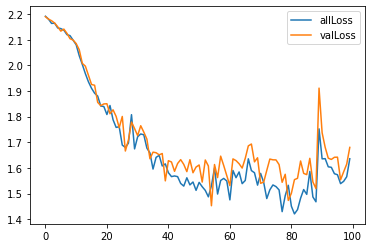

In [212]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses, label='allLoss')
plt.plot(val_losses, label='valLoss')
plt.legend()

In [213]:
print("Final validation loss for RNN is: %f" % val_losses[-1])

Final validation loss for RNN is: 1.679882


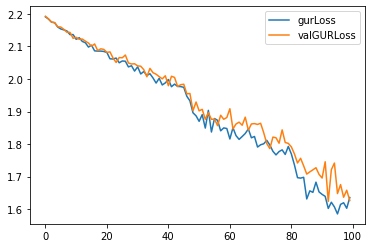

In [214]:
plt.figure()
plt.plot(all_losses_gru, label='gurLoss')
plt.plot(val_losses_gru, label='valGURLoss')
plt.legend()

In [215]:
print("Final validation loss for GRU is: %f" % val_losses_gru[-1])

Final validation loss for GRU is: 1.626604


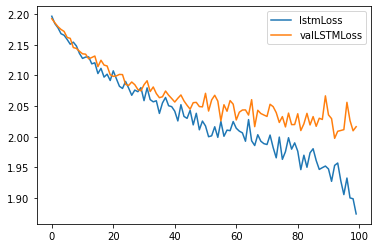

In [216]:
plt.figure()
plt.plot(all_losses_lstm, label='lstmLoss')
plt.plot(val_losses_lstm, label='valLSTMLoss')
plt.legend()

In [217]:
print("Final validation loss for LSTM is: %f" % val_losses_lstm[-1])

Final validation loss for LSTM is: 2.016303


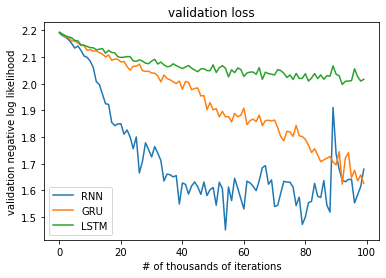

In [218]:
plt.figure()
plt.title('validation loss')
plt.plot(val_losses, label='RNN')
plt.plot(val_losses_gru, label='GRU')
plt.plot(val_losses_lstm, label='LSTM')
plt.xlabel("# of thousands of iterations")
plt.ylabel("validation negative log likelihood")
plt.legend()

<ipython-input-219-a5b341ffc3a3>:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=90)
<ipython-input-219-a5b341ffc3a3>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


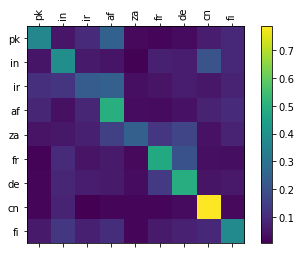

In [219]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

In [220]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')


> Dovesky
(-1.42) fr
(-1.62) za
(-1.67) de

> Jackson
(-1.49) de
(-2.10) in
(-2.15) cn

> Satoshi
(-1.18) cn
(-1.98) fi
(-2.12) ir
